In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import shutil
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Parameters
learning_rate = 0.01
#num_steps = 100
batch_size = 16
display_step = 100

# Images
toClassify = "Cardiomegaly"
IMG_HEIGHT = 250
IMG_WIDTH = 250
CH = 3
image_dir = "M:\\DataSets\\chestrays\\source\\" # XPS
rows = 4001 # number 
train_rows = 3000
test_rows = 1000

**Use pandas to take a quick peek at the sheet**


In [3]:
df = pd.read_csv("chestrays.csv", header=None, na_values="?")
df = df.iloc[1:rows]
df.head()

C:\Users\Tony\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,3,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,0,1,2,3,4,5,6,7,8,9,10
1,00000001_000.png,Cardiomegaly,0,1,058Y,M,PA,2682,2749,0.143,0.143
2,00000001_001.png,Cardiomegaly|Emphysema,1,1,058Y,M,PA,2894,2729,0.143,0.143
3,00000001_002.png,Cardiomegaly|Effusion,2,1,058Y,M,PA,2500,2048,0.168,0.168
4,00000002_000.png,No Finding,0,2,081Y,M,PA,2500,2048,0.171,0.171
5,00000003_000.png,Hernia,0,3,081Y,F,PA,2582,2991,0.143,0.143


In [4]:
# Prepare train and test sets

# Factorize the labels and make the directories, convert all | to _'s, remove spaces
labels, names = pd.factorize(df[1])
image_names = image_dir + df.iloc[0:rows,0].values

# data mover function, also populates the dictionary so we can see the distribution of data
def copyImages(dataframe, idx, directory="train"):
    classification = dataframe.iloc[idx][1].replace(" ","").replace("|","_")
    source = image_dir + dataframe.iloc[idx][0]
    destination = directory + "/"
    
    if classification == "NoFinding":
        shutil.copy(source, destination + "NoFinding")
    elif classification.find(toClassify) >= 0:
        shutil.copy(source, destination + toClassify)

        
# Make classification directories
pathlib.Path("train/" + "NoFinding").mkdir(parents=True, exist_ok=True)
pathlib.Path("train/" + toClassify).mkdir(parents=True, exist_ok=True)
pathlib.Path("test/" + "NoFinding").mkdir(parents=True, exist_ok=True)
pathlib.Path("test/" + toClassify).mkdir(parents=True, exist_ok=True)


for r in range(train_rows):
    copyImages(df, r, "train")

for r in range(test_rows):
    copyImages(df, train_rows + r, "test")


num_classes = len(list(set(labels)))
print('Number of rows: {}'.format(len(labels))) 
print(names[:10])

Number of rows: 4000
Index(['Cardiomegaly', 'Cardiomegaly|Emphysema', 'Cardiomegaly|Effusion',
       'No Finding', 'Hernia', 'Hernia|Infiltration', 'Mass|Nodule',
       'Infiltration', 'Effusion|Infiltration', 'Nodule'],
      dtype='object')


--------------------------------------------------------------------------

Take a peek of some images and also use TF to resize it without distortion

------------------------------------------------------------------------------

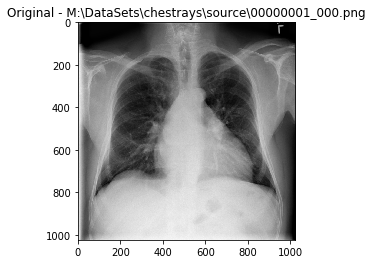

In [5]:
img=mpimg.imread(image_names[0])

imgplot = plt.imshow(img, cmap='gray')
plt.title('Original - ' + image_names[0])
plt.show()

In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, CH)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

sgd = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=["accuracy"])


In [7]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of './train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'train',  # this is the target directory
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=batch_size,
        class_mode='binary')

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=batch_size,
        class_mode='binary')

print(validation_generator.class_indices)

Found 1737 images belonging to 2 classes.
Found 617 images belonging to 2 classes.
{'NoFinding': 1, 'Cardiomegaly': 0}


In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=train_rows // batch_size,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800 // batch_size)

Epoch 1/50
187/187 [==============================] - 50s 267ms/step - loss: 1.3609 - acc: 0.9142 - val_loss: 0.7036 - val_acc: 0.9559
Epoch 2/50
187/187 [==============================] - 47s 254ms/step - loss: 1.3735 - acc: 0.9138 - val_loss: 0.6634 - val_acc: 0.9584
Epoch 3/50
187/187 [==============================] - 47s 249ms/step - loss: 1.4375 - acc: 0.9098 - val_loss: 0.6433 - val_acc: 0.9596
Epoch 4/50
187/187 [==============================] - 47s 250ms/step - loss: 1.4440 - acc: 0.9094 - val_loss: 0.8243 - val_acc: 0.9483
Epoch 5/50
187/187 [==============================] - 48s 257ms/step - loss: 1.3428 - acc: 0.9158 - val_loss: 0.6634 - val_acc: 0.9584
Epoch 6/50
187/187 [==============================] - 47s 249ms/step - loss: 1.4256 - acc: 0.9106 - val_loss: 0.7237 - val_acc: 0.9546
Epoch 7/50
187/187 [==============================] - 47s 250ms/step - loss: 1.4306 - acc: 0.9102 - val_loss: 0.6433 - val_acc: 0.9596
Epoch 8/50
156/187 [========================>.....] - E

In [ ]:
from keras.preprocessing import image
img = image.load_img(image_dir + "00001326_002.png", target_size=(IMG_WIDTH, IMG_HEIGHT))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = np.vstack([x]) # just append to this if we have more than one image.
classes = model.predict_classes(x)
print(classes)
